In [1]:
import pandas as pd
from plotly import graph_objects as go
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from datetime import timedelta
from dateutil.relativedelta import relativedelta
import numpy as np
import optuna
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_squared_error
import logging
from copy import deepcopy
from statsmodels.tsa.seasonal import seasonal_decompose
from plotly.subplots import make_subplots
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools

d:\Programms\Programming\PythonProjects\A1_test\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data import

In [2]:
df = pd.read_excel('tasks_1-2.xlsx', sheet_name='Timeseries', date_format='%Y-%m-%d', parse_dates=['Date'])

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1642 entries, 0 to 1641
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     1642 non-null   datetime64[ns]
 1   series1  1642 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 25.8 KB


In [4]:
df.head(10)

,Date,series1
0,2015-01-01,1006.699649
1,2015-01-02,3197.751826
2,2015-01-03,3217.491035
3,2015-01-04,2151.573759
4,2015-01-05,4243.929892
5,2015-01-06,3178.012617
6,2015-01-07,1816.007210
7,2015-01-08,3020.098947
8,2015-01-09,3671.492837
9,2015-01-10,3138.534200


In [5]:
df['Date'].iloc[-1].date()

datetime.date(2019, 6, 30)

## Plots

In [6]:
# Plotting relation between date and series1 feature plot
fig = go.Figure()
fig.add_trace(
    go.Scatter(x=df['Date'], y=df['series1'], mode='lines')
)
fig.show()

In [7]:
# Seasonal decompose
decomposition_df = df.copy()
decomposition_df.set_index('Date', inplace=True)
decomposition = seasonal_decompose(decomposition_df, model='multiplicative')
fig = make_subplots(rows=4, cols=1,
                    subplot_titles=["Observed", "Trend", "Seasonal", "Residuals"],)
fig.add_trace(
    go.Scatter(x=decomposition_df.index, y=decomposition.observed, mode="lines", name='Observed'),
    row=1,
    col=1,
)
fig.add_trace(
    go.Scatter(x=decomposition_df.index, y=decomposition.trend, mode="lines", name='Trend'),
    row=2,
    col=1,
)
fig.add_trace(
    go.Scatter(x=decomposition_df.index, y=decomposition.seasonal, mode="lines", name='Seasonal'),
    row=3,
    col=1,
)
fig.add_trace(
    go.Scatter(x=decomposition_df.index, y=decomposition.resid, mode="lines", name='Residual'),
    row=4,
    col=1,
)
fig.update_layout(title='Seasonal decomposition', height=1080, width=1920)
fig.show()

## Time-series statistical tests

In [8]:
# ADF test
adf_test = adfuller(df['series1'])
print(f'ADF Statistic: {adf_test[0]}')
print(f'p-value: {adf_test[1]}')
print(f'Series is stationary (around unit root)? {"Yes" if adf_test[1] < 0.05 else "No"}')

ADF Statistic: -5.496713808722672
p-value: 2.1154012725975373e-06
Series is stationary (around unit root)? Yes


In [26]:
# KPSS test
kpss_test = kpss(df['series1'], regression='ct')
print(f'KPSS statistics: {kpss_test[0]}')
print(f'p-value: {kpss_test[1]}')
print(f'Series is stationary (around trend)? {"Yes" if kpss_test[1] > 0.05 else "No"}')

KPSS statistics: 0.1819907816436792
p-value: 0.022753456883620293
Series is stationary (around trend)? No


## SARIMAX preparation and usage (with Optuna)

In [10]:
# Bondary date for train/test split
boundary_date = df['Date'].iloc[-1].date() - relativedelta(months=3)
boundary_date

datetime.date(2019, 3, 30)

In [11]:
# Creating train/test dataframes
sarimax_df_train = df[df['Date'].dt.date <= boundary_date].set_index('Date')
sarimax_df_test = df[df['Date'].dt.date > boundary_date]

In [ ]:
# Optuna objective
p = range(1, 3)  # Smaller range for non-seasonal AR component
d = range(0, 2)
q = range(0, 3)
P = range(0, 2)  # Smaller range for seasonal AR component
D = range(0, 2)
Q = range(0, 2)
s = 12

pdq = list(itertools.product(p, d, q))
pdqs = [(x[0], x[1], x[2], s) for x in list(itertools.product(P, D, Q))]

def objective(trial: optuna.Trial):
    order = trial.suggest_categorical('order', pdq)
    seasonal_order = trial.suggest_categorical('seasonal_order', pdqs)
    trend = trial.suggest_categorical('trend', ['n', 'c', 't', 'ct', None])
        
    model = SARIMAX(sarimax_df_train, order=order, seasonal_order=seasonal_order, freq='D',
                    trend=trend, initialization='approximate_diffuse')
    results = model.fit(disp=0)
    predictions = results.forecast(len(sarimax_df_test))            
    return root_mean_squared_error(sarimax_df_test['series1'],
                                   predictions.values)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

[I 2024-11-15 12:27:15,499] A new study created in memory with name: no-name-af4fbf70-fc41-4b1d-a544-aafc88163d2f
d:\Programms\Programming\PythonProjects\A1_test\.venv\Lib\site-packages\optuna\distributions.py:524: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 0, 0) which is of type tuple.

d:\Programms\Programming\PythonProjects\A1_test\.venv\Lib\site-packages\optuna\distributions.py:524: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 0, 1) which is of type tuple.

d:\Programms\Programming\PythonProjects\A1_test\.venv\Lib\site-packages\optuna\distributions.py:524: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 0, 2) which is of type tuple.

d:\Programms\Programming\PythonProjects\A1_test\.venv\L

In [13]:
# After Optuna optimizing
model = SARIMAX(sarimax_df_train,
                freq='D',
                initialization='approximate_diffuse',
                **study.best_params)
results = model.fit()
predictions = results.predict(start=df['Date'].iloc[0], end=df['Date'].iloc[-1], dynamic=False)
df_predict = pd.DataFrame(data={'Date': df['Date'],
                          'series1': predictions.values})

d:\Programms\Programming\PythonProjects\A1_test\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

d:\Programms\Programming\PythonProjects\A1_test\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [14]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                series1   No. Observations:                 1550
Model:               SARIMAX(2, 0, 1)   Log Likelihood              -12509.469
Date:                Fri, 15 Nov 2024   AIC                          25028.937
Time:                        12:27:38   BIC                          25055.667
Sample:                    01-01-2015   HQIC                         25038.879
                         - 03-30-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          0.0143      0.012      1.189      0.235      -0.009       0.038
ar.L1          1.3624      0.031     43.873      0.000       1.302       1.423
ar.L2         -0.3663      0.030    -12.252      0.000      -0.425      -0.308
ma.L1         -0.7904      0.022    -36.058      0.000      -0.833      -0.747
sigma2      6.111e+05    1.1e+04     55.598      0.000     5.9e+05    6.33e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.86   Jarque-Bera (JB):             16572.81
Prob(Q):                              0.35   Prob(JB):                         0.00
Heteroskedasticity (H):               1.11   Skew:                            -1.30
Prob(H) (two-sided):                  0.22   Kurtosis:                        18.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

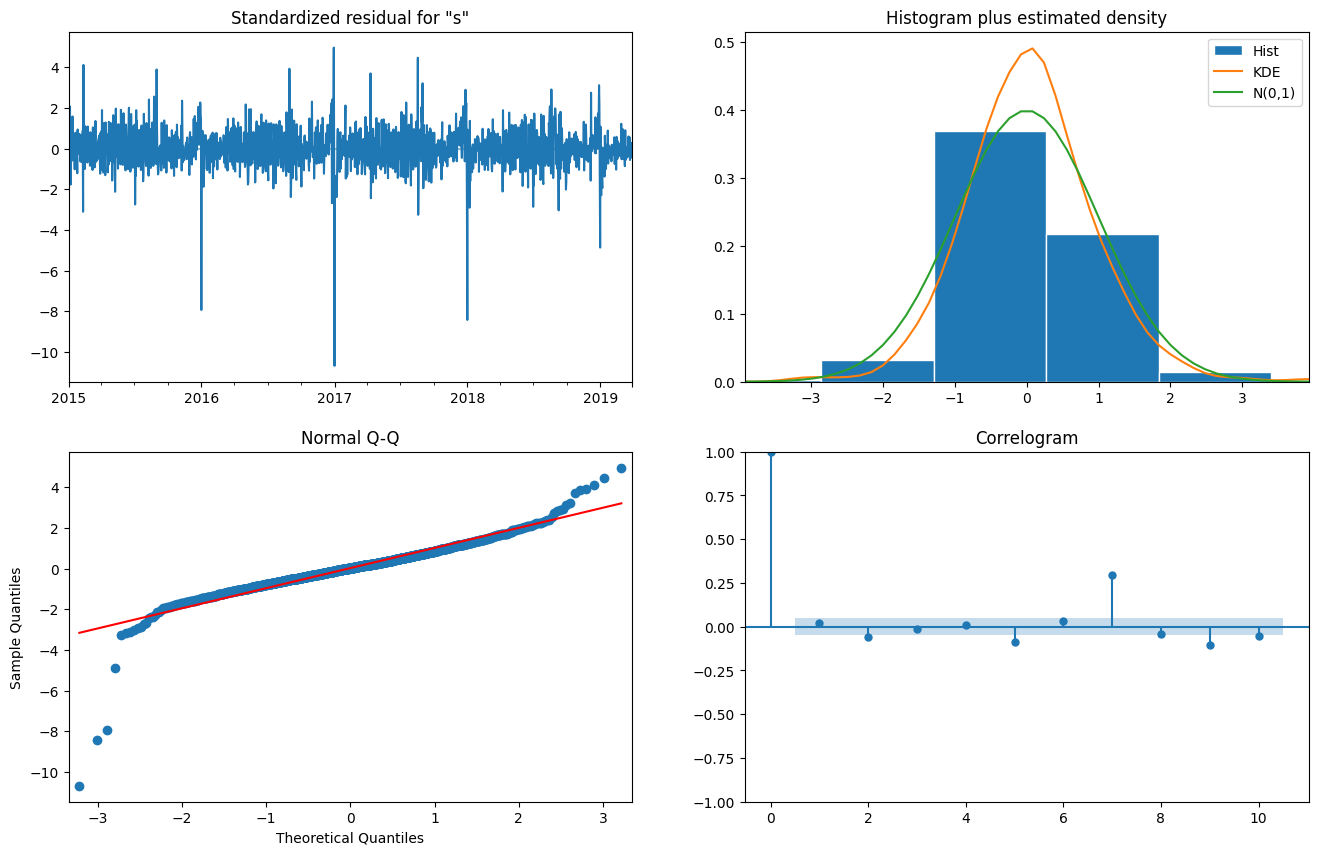

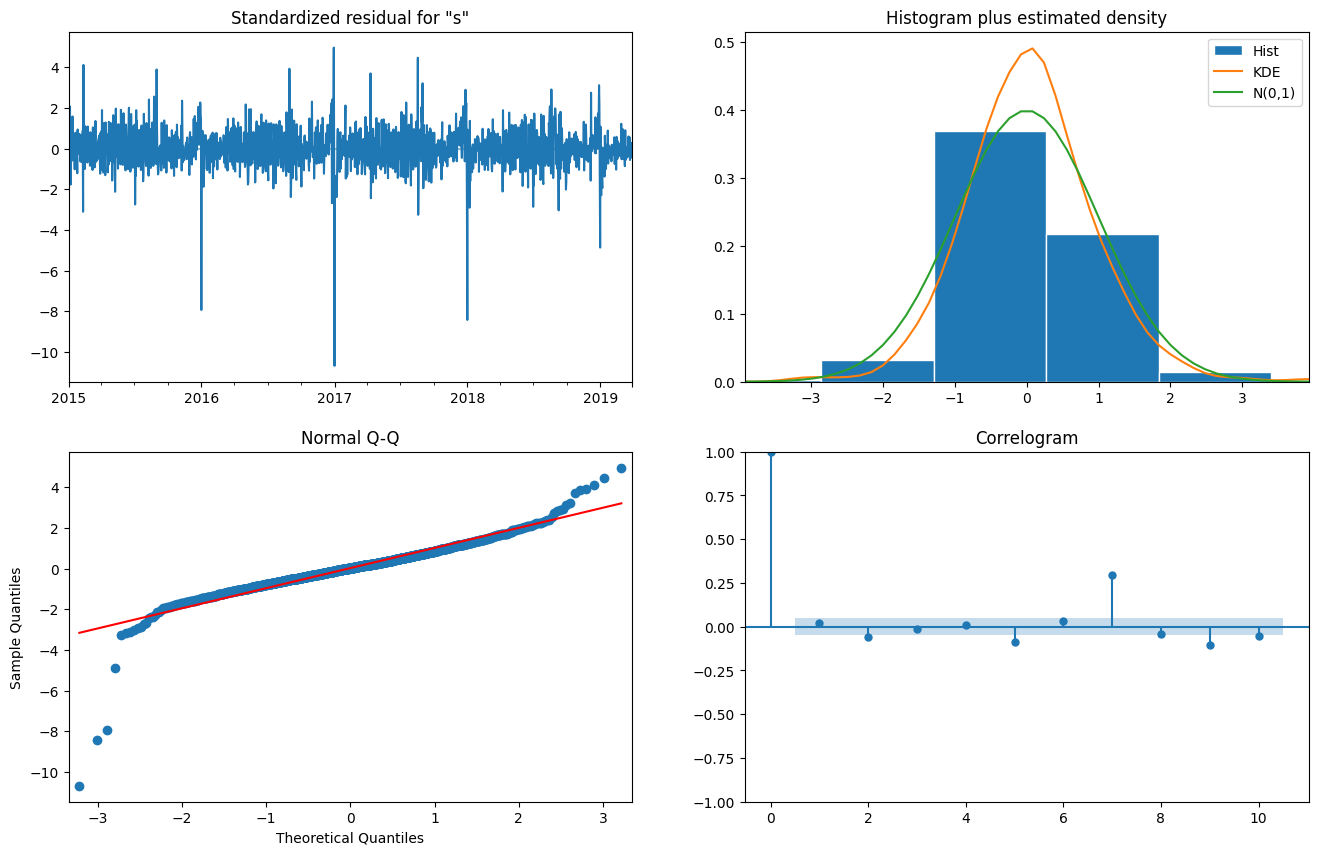

In [15]:
results.plot_diagnostics(figsize=(16,10))

In [16]:
# Metrics after creating optuna-optimized SARIMAX model
mae_train = mean_absolute_error(sarimax_df_train['series1'],
                                df_predict[df_predict['Date'].dt.date <= boundary_date]['series1'])
mae_test = mean_absolute_error(sarimax_df_test['series1'],
                               df_predict[df_predict['Date'].dt.date > boundary_date]['series1'])
print(f'MAE train: {mae_train}')
print(f'MAE test: {mae_test}')

MAE train: 545.1415417594903
MAE test: 411.6311380091769


In [17]:
# Plot of original, predicted time series
fig = go.Figure()
fig.add_trace(
    go.Scatter(x=df['Date'], y=df['series1'], mode='lines', name='Real data')    
)
fig.add_trace(
    go.Scatter(x=df_predict['Date'], y=df_predict['series1'], mode='lines', name='Predicted data')
)
fig.update_layout(title='SARIMAX + Optuna')
fig.show()

In [18]:
# Prediction for three more new months
three_more_months_predictions = results.predict(start=df['Date'].iloc[-1] + pd.DateOffset(days=1),
                                                end=df['Date'].iloc[-1] + pd.DateOffset(months=3),
                                                dynamic=False)
fig = go.Figure()
fig.add_trace(
    go.Scatter(x=df['Date'], y=df['series1'], mode='lines', name='Real data')    
)
fig.add_trace(
    go.Scatter(x=pd.date_range(df['Date'].iloc[-1],
                               df['Date'].iloc[-1] + pd.DateOffset(months=3),
                               freq='D', inclusive='right'),
               y=three_more_months_predictions.values,
               mode='lines', name='3-month predicted data')
)
fig.update_layout(title='SARIMAX + Optuna (3 new months prediction)')
fig.show()

## Prophet + Optuna

In [19]:
# Bondary date for train/test split
boundary_date = df['Date'].iloc[-1].date() - relativedelta(months=3)
boundary_date

datetime.date(2019, 3, 30)

In [20]:
# Preparing datasets for Prophet
prophet_df_train = df[df['Date'].dt.date <= boundary_date].rename(columns={'Date': 'ds', 'series1': 'y'})
prophet_df_test = df[df['Date'].dt.date > boundary_date].rename(columns={'Date': 'ds', 'series1': 'y'})

In [21]:
def objective(trial: optuna.Trial):
    params = {
        'seasonality_prior_scale': trial.suggest_float('seasonality_prior_scale', 0.1, 100),
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.001, 10),
        'seasonality_mode': trial.suggest_categorical('seasonality_mode', ['additive', 'multiplicative']),
        'changepoint_range': trial.suggest_float('changepoint_range', 0.5, 1),
        'n_changepoints': trial.suggest_int('n_changepoints', 10, 200),                        
    }    
    ph = Prophet(weekly_seasonality=False,
                 daily_seasonality=False,
                 yearly_seasonality=True,                                               
                 **params)
    ph.add_seasonality(name='custom_seasonality',
                       period=trial.suggest_int('custom_seasonality_period', 30, 120),
                       fourier_order=trial.suggest_int('custom_seasonality_order', 2, 5))   
    ph.fit(prophet_df_train)
    # df_cv = cross_validation(ph, horizon='90 days', period='90 days', initial='730 days', parallel="processes")
    # metrics = performance_metrics(df_cv, rolling_window=1)
    df_future = ph.make_future_dataframe(periods=len(prophet_df_test), freq='D')
    df_predict = ph.predict(df_future)
    return mean_absolute_error(df[df['Date'].dt.date > boundary_date]['series1'],
                               df_predict[df_predict['ds'].dt.date > boundary_date]['yhat'])

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

[I 2024-11-15 12:27:39,451] A new study created in memory with name: no-name-33888fd0-39d8-4135-b36c-c50ec04f2503
12:27:39 - cmdstanpy - INFO - Chain [1] start processing
12:27:40 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 12:27:41,054] Trial 0 finished with value: 510.1487970988967 and parameters: {'seasonality_prior_scale': 80.51554325420943, 'changepoint_prior_scale': 8.346895848296846, 'seasonality_mode': 'additive', 'changepoint_range': 0.7301103575355941, 'n_changepoints': 39, 'custom_seasonality_period': 107, 'custom_seasonality_order': 4}. Best is trial 0 with value: 510.1487970988967.
12:27:41 - cmdstanpy - INFO - Chain [1] start processing
12:27:42 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 12:27:42,567] Trial 1 finished with value: 451.8796686635918 and parameters: {'seasonality_prior_scale': 27.37398318947463, 'changepoint_prior_scale': 0.32938229164906013, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.5916751022161483, 'n_

In [22]:
# Initializing model with best params found by optuna
prophet_params = {k: study.best_params[k] for k in study.best_params
                  if k not in ['custom_seasonality_period', 'custom_seasonality_order']}
ph = Prophet(weekly_seasonality=False,
             daily_seasonality=False,
            #  yearly_seasonality=True,                          
             **prophet_params)
ph.add_seasonality(name='custom_seasonality',
                   period=study.best_params['custom_seasonality_period'],
                   fourier_order=study.best_params['custom_seasonality_order'])
ph.fit(prophet_df_train)
df_future = ph.make_future_dataframe(periods=len(prophet_df_test), freq='D')
df_future['ds'].iloc[-1].date()
df_predict = ph.predict(df_future)

12:29:49 - cmdstanpy - INFO - Chain [1] start processing
12:29:53 - cmdstanpy - INFO - Chain [1] done processing


In [23]:
# Metrics after just Propher with some hyperparameters found by optuna
mae_train = mean_absolute_error(df[df['Date'].dt.date <= boundary_date]['series1'],
                                df_predict[df_predict['ds'].dt.date <= boundary_date]['yhat'])
mae_test = mean_absolute_error(df[df['Date'].dt.date > boundary_date]['series1'],
                               df_predict[df_predict['ds'].dt.date > boundary_date]['yhat'])
print(f'MAE train: {mae_train}')
print(f'MAE test: {mae_test}')

MAE train: 593.0075681937367
MAE test: 420.47973290662446


In [24]:
fig = go.Figure()
fig.add_trace(
    go.Scatter(x=df['Date'], y=df['series1'], mode='lines', name='Real data')    
)
fig.add_trace(
    go.Scatter(x=df_predict['ds'], y=df_predict['yhat'], mode='lines', name='Predicted data')
)
fig.add_trace(
    go.Scatter(x=df_predict['ds'], y=df_predict['yhat_upper'], mode='lines', name='Predicted data upper')
)
fig.add_trace(
    go.Scatter(x=df_predict['ds'], y=df_predict['yhat_lower'], mode='lines', name='Predicted data lower')
)
fig.update_layout(title='Prophet + Optuna')
fig.show()

In [25]:
# Three more month predict for Prophet + Optuna model
three_more_month_df = pd.DataFrame(data={'ds': pd.date_range(df['Date'].iloc[-1].date(),
                                                             df['Date'].iloc[-1].date() + relativedelta(months=3),
                                                             inclusive='right',
                                                             freq=timedelta(days=1),
                                                             normalize=True)})
three_more_month_predicted = ph.predict(three_more_month_df)
fig = go.Figure()
fig.add_trace(
    go.Scatter(x=df['Date'], y=df['series1'], mode='lines', name='Real data')    
)
fig.add_trace(
    go.Scatter(x=three_more_month_predicted['ds'],
               y=three_more_month_predicted['yhat'], mode='lines', name='3-month predicted data')
)
fig.add_trace(
    go.Scatter(x=three_more_month_predicted['ds'],
               y=three_more_month_predicted['yhat_upper'], mode='lines', name='3-month predicted data upper')
)
fig.add_trace(
    go.Scatter(x=three_more_month_predicted['ds'],
               y=three_more_month_predicted['yhat_lower'], mode='lines', name='3-month predicted data lower')
)
fig.update_layout(title='Prophet + Optuna (3 new months prediction)')
fig.show()